In [1]:
import pandas as pd
import pytrends
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 

In [2]:
from pytrends.request import TrendReq

In [3]:
pytrends = TrendReq(hl='en-US', tz=360)

In [4]:
kw_list =["ESG"]
pytrends.build_payload(kw_list, geo ='GR')

In [5]:
df=pytrends.interest_over_time()

In [6]:
df.to_csv("greekGoogleTrendEsg.csv",sep=';')
df.head()
df['ESG'].dtype

dtype('int64')

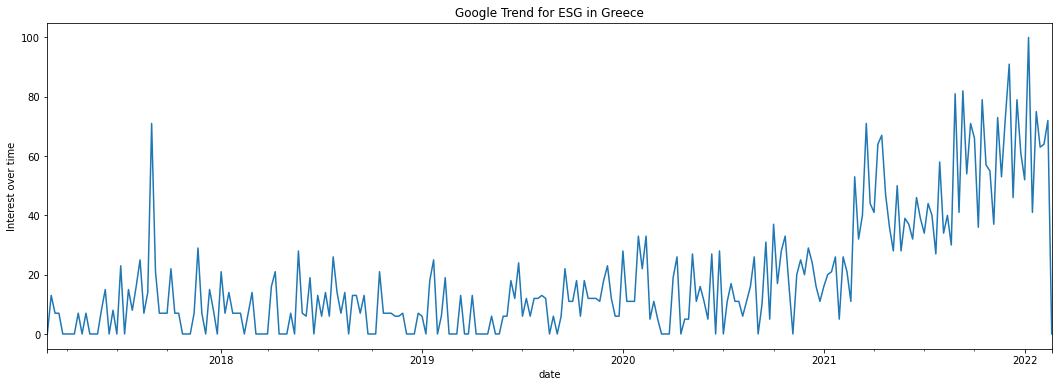

In [7]:
title='Google Trend for ESG in Greece'
ylabel='Interest over time'
ax=df['ESG'].plot(figsize=(18,6),title=title)
ax.set(ylabel=ylabel);

## ETS Decompositon model

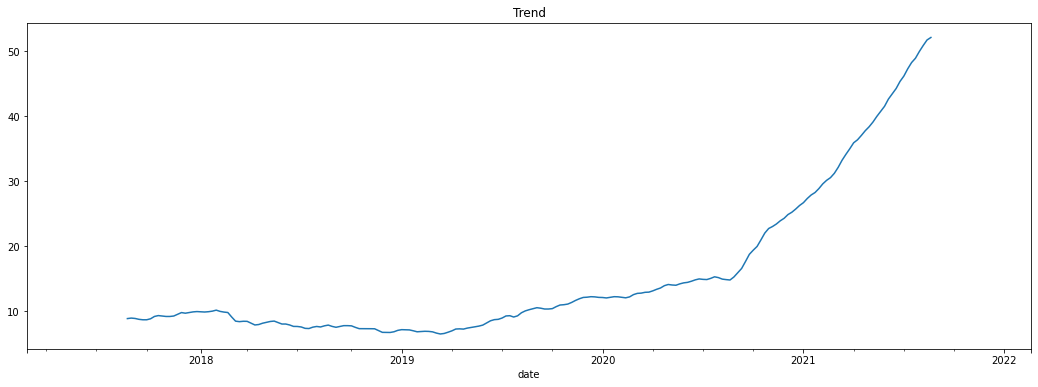

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
rcParams['figure.figsize']=18,6

df.dropna(inplace=True)
result=seasonal_decompose(df['ESG'],model='additive')
result.trend.plot(title = "Trend");

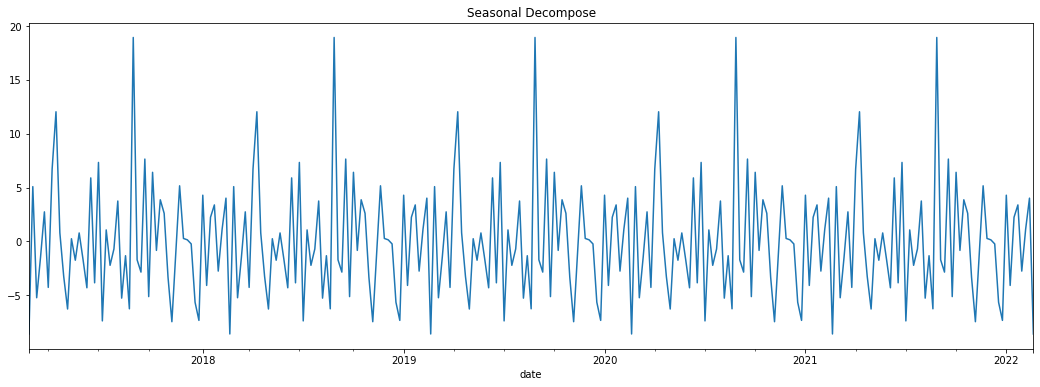

In [9]:
result.seasonal.plot(title="Seasonal Decompose", figsize=(18,6));

## 6-Month Simple Moving Average(SMA)

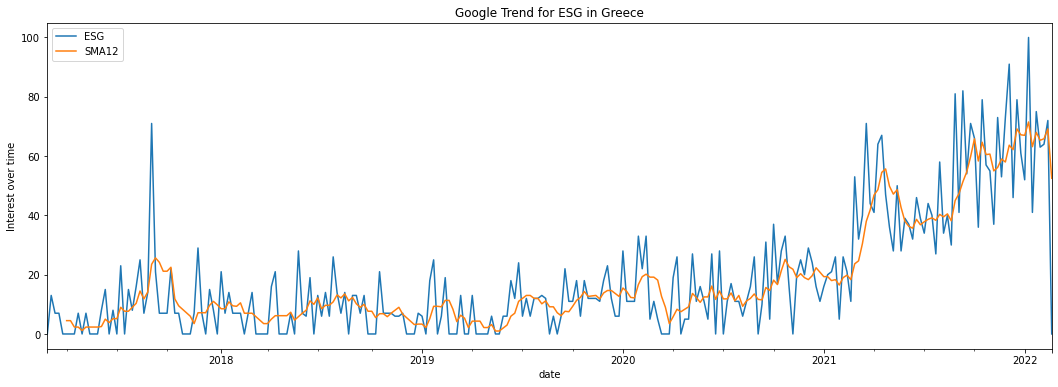

In [10]:
# 12months Simple Moving Average
df['SMA12']=df['ESG'].rolling(window=6).mean()
df[['ESG','SMA12']].plot(figsize=(18,6), title = title).set(ylabel = ylabel);

## Adding Exponentially Weighted Movining Average(EWMA) with 6 month span

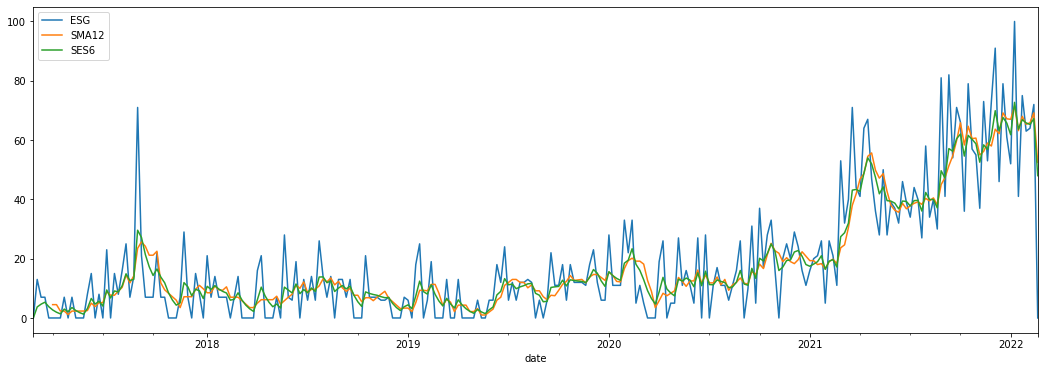

In [11]:
df['SES6']=df['ESG'].ewm(span=6,adjust=False).mean()
# df.head()
df[['ESG','SMA12','SES6']].plot();

## Adding Holt-Winters fitted model using Triple Exponential Smoothing with additive model

/home/giorgos/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


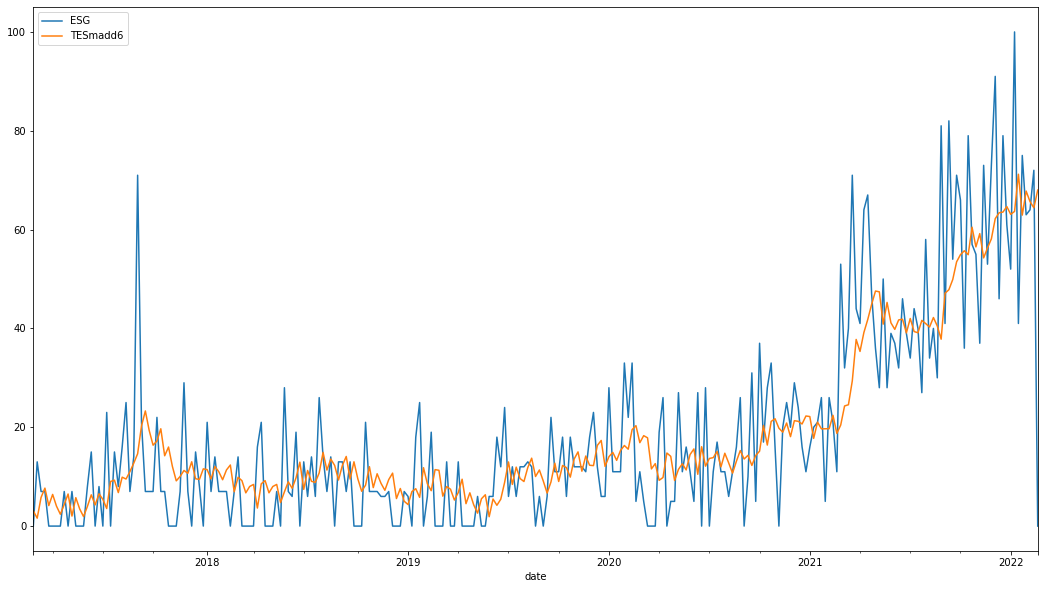

In [12]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
df['TESmadd6']=ExponentialSmoothing(df['ESG'],trend='add',seasonal='add',seasonal_periods=6).fit().fittedvalues;
# df.head()
# df.columns
df[['ESG','TESmadd6']].plot(figsize=(18,10));

### ESG google search in Greece for the last 2 years

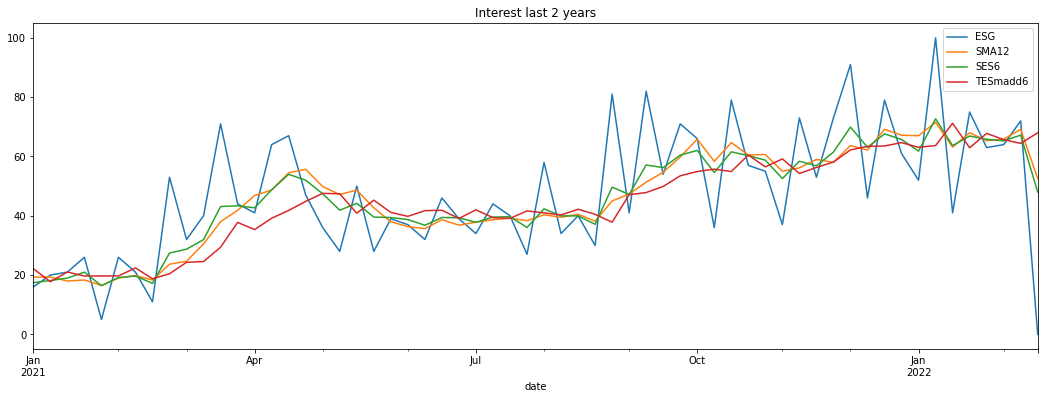

In [13]:
df[['ESG', 'SMA12', 'SES6', 'TESmadd6']]['2021-01-01':].plot(title='Interest last 2 years');

# Forcasting ESG google trend for Greece

## 1. Forecast with Holt-Winters model

In [44]:
# Split Data set to Train-Test set
df.info()
train_set = round(261*.8)
test_set = len(df)-train_set
train=df.iloc[:train_set]
test = df.iloc[train_set-5:]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 261 entries, 2017-02-26 to 2022-02-20
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ESG        261 non-null    int64  
 1   isPartial  261 non-null    bool   
 2   SMA12      256 non-null    float64
 3   SES6       261 non-null    float64
 4   TESmadd6   261 non-null    float64
dtypes: bool(1), float64(3), int64(1)
memory usage: 18.6 KB


In [45]:
train.tail()

,ESG,isPartial,SMA12,SES6,TESmadd6
date,,,,,
2021-01-24,26,False,18.333333,20.986077,19.677458
2021-01-31,5,False,16.500000,16.418626,19.703711
2021-02-07,26,False,19.000000,19.156162,19.708016
2021-02-14,21,False,19.833333,19.682973,22.416132
2021-02-21,11,False,18.333333,17.202123,18.762376


In [46]:
test.head()

,ESG,isPartial,SMA12,SES6,TESmadd6
date,,,,,
2021-01-24,26,False,18.333333,20.986077,19.677458
2021-01-31,5,False,16.500000,16.418626,19.703711
2021-02-07,26,False,19.000000,19.156162,19.708016
2021-02-14,21,False,19.833333,19.682973,22.416132
2021-02-21,11,False,18.333333,17.202123,18.762376


In [69]:
# Fit the model
fitted_model = ExponentialSmoothing(train['ESG'],trend='add',seasonal='add').fit()

/home/giorgos/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


In [70]:
# Forecast against test set
test_pred = fitted_model.forecast(90)
test_pred

2021-02-28    17.054292
2021-03-07    10.554221
2021-03-14    12.554267
2021-03-21     7.554288
2021-03-28     7.554369
                ...    
2022-10-16    25.245454
2022-10-23    24.245477
2022-10-30    18.495491
2022-11-06    14.495471
2022-11-13    20.995528
Freq: W-SUN, Length: 90, dtype: float64

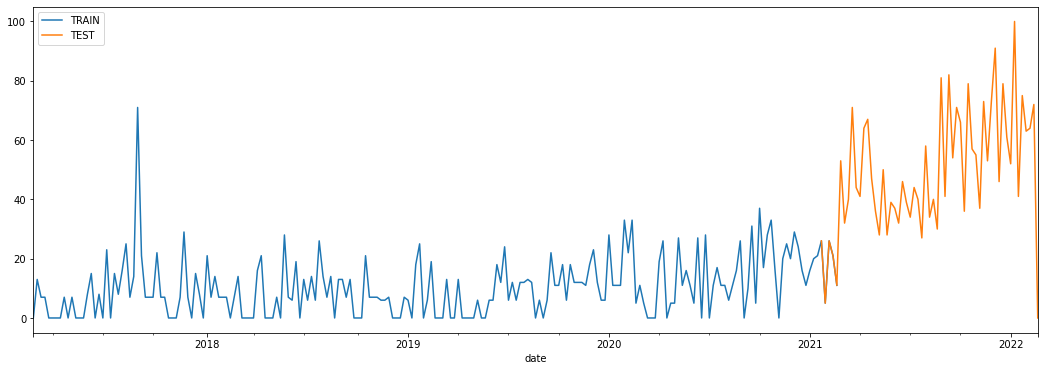

In [71]:
# plot train and test data
train['ESG'].plot(legend = True, label = 'TRAIN')
test['ESG'].plot(legend = True, label = 'TEST');

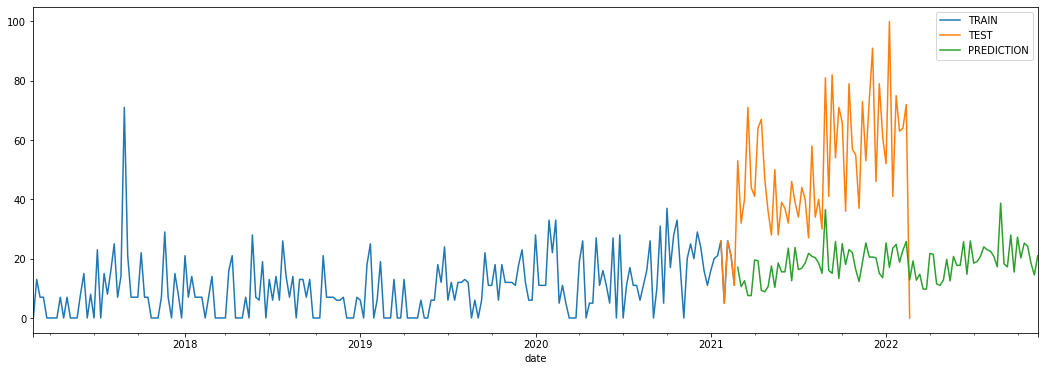

In [72]:
# Plot with prediction
train['ESG'].plot(legend = True, label = 'TRAIN')
test['ESG'].plot(legend = True, label = 'TEST')
test_pred.plot(legend = True, label='PREDICTION');